# BirdBran.AI

# 0. Introduction

This notebook is part of our work on the topic **_Bird Classification_** for the module *Machine Learning Project* in course *WWI20DSB* supervised by Prof. Dr. Maximilian Scherer at the Baden-Wuerttemberg Cooperative State University Mannheim.

Team Members:
- Annika Dackermann (5562028)
- Valentin Moritz Müller (4616344)
- Max Bernauer (5763624)


This notebook focuses on the *Recognition* of the bird in form of an image classification model. The data set [BIRDS 525 SPECIES- IMAGE CLASSIFICATION](https://www.kaggle.com/datasets/gpiosenka/100-bird-species) is used. The model is implemented with the deep learning library *TensorFlow* and its architecture is derived from EfficientNetB3. The trained model can be found here: (https://drive.google.com/drive/folders/1hnJDG6kKPq4EjY-3V5b0H-XjmmiKk7Kg?usp=drive_link)


# 1. Prequesites

## 1.1 Download Data Set

* prerequisite: personal access token for kaggle is stored in an kaggle.json file in either the root dir of this runtime enviromnemt or in google drive
* will download the dataset and store it unzipped it in the content dir
* will lead to following directories for the GTSRB data set
    * train: `/content/100-bird-species/train`
    * test:  `/content/100-bird-species/test`
    * valid: `/content/100-bird-species/train`

In [1]:
# connect to google drive --> allows to store kaggle.json API token under the main folder in the drive,
#   so that it doesn't have to be uploaded every time
# Alternatively the kaggle.json can be uploaded under /content/

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Setting up kaggle for this environment:

In [2]:
! pip install kaggle
! mkdir -p ~/.kaggle/
# for the case, that kaggle.json is stored in the drive
! cp drive/MyDrive/kaggle.json ~/.kaggle/
# for the case, if kaggle.json is stored under the root dir
# ! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Downloading and unpacking the data set:

In [3]:
# download the bird image dataset and unzip images in the data directory
! kaggle datasets download -d gpiosenka/100-bird-species
! unzip -n -q 100-bird-species.zip -d 100-bird-species

100-bird-species.zip: Skipping, found more recently modified local copy (use --force to force download)


## 1.2 Imports

In [4]:
import glob
from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd
import os
import cv2

import tensorflow as tf
from tensorflow.keras import layers, models, Model
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.utils import plot_model, image_dataset_from_directory


if tf.__version__[:5] != '2.13.':
  !pip uninstall tensorflow -y
  !pip install  tensorflow==2.13.*

# a restart if required after updating tensorflow, this assertion is used to remind the user
# and avoid training a model for hours in a tf-version that has the save-bug
assert tf.__version__[:5] == '2.13.'

tf.__version__

'2.13.0'

In [5]:
physical_devices = tf.config.list_physical_devices('GPU')

print("GPU:", tf.config.list_physical_devices('GPU'))
print("Num GPUs:", len(physical_devices))

GPU: []
Num GPUs: 0


## 1.3 Configuration

In [6]:
# should be in ['VGG16', 'EfficientNetB0', 'EfficientNetB3', 'EfficientNetB5', 'EfficientNetB7'], defaults to 'ResNet'
architecture = 'EfficientNetB3'

trainable = False

weights = 'imagenet'

In [7]:
sns.set_style('darkgrid')

# 2. Data Preparation

## 2.1 Input

First, the meta data of the images is loaded from the downloaded csv to get an overview before loading the actual images.

In [8]:
data = pd.read_csv('/content/100-bird-species/birds.csv')
data = data.replace(['PARAKETT  AKULET'],'PARAKETT  AUKLET') # fixing an syntax error in one of the bird names
data = data.rename(columns={"data set": "data_set"}) # renaming a column of the data set to make it callable
data.head()

class id                      filepaths           labels data_set  \
0       0.0  train/ABBOTTS BABBLER/001.jpg  ABBOTTS BABBLER    train   
1       0.0  train/ABBOTTS BABBLER/007.jpg  ABBOTTS BABBLER    train   
2       0.0  train/ABBOTTS BABBLER/008.jpg  ABBOTTS BABBLER    train   
3       0.0  train/ABBOTTS BABBLER/009.jpg  ABBOTTS BABBLER    train   
4       0.0  train/ABBOTTS BABBLER/002.jpg  ABBOTTS BABBLER    train   

        scientific name  
0  MALACOCINCLA ABBOTTI  
1  MALACOCINCLA ABBOTTI  
2  MALACOCINCLA ABBOTTI  
3  MALACOCINCLA ABBOTTI  
4  MALACOCINCLA ABBOTTI

## 2.2 Data Exploration

Second, the data is splitted into train, test and validation set to get an overview of how much images are in each set.

In [9]:
data_train = data.drop(data[(data.data_set == 'test') | (data.data_set == 'valid')].index)
data_test = data.drop(data[(data.data_set == 'train') | (data.data_set == 'valid')].index)
data_valid = data.drop(data[(data.data_set == 'train') | (data.data_set == 'test')].index)

In [10]:
print('Images in the train set: ', len(data_train))
print('Images in the test set: ', len(data_test))
print('Images in the validation set: ', len(data_valid))

Images in the train set:  84635
Images in the test set:  2625
Images in the validation set:  2625


Third, the training data is checked regarding the distribution of the classes. The 10 classes with the highest/lowest number of samples are plotted to show the biggest sample difference.

In [14]:
number_of_classes_to_select = 10 # selects the 10 classes with the highest/smallest number of images

train_number = data.groupby(by=['labels']).count()['class id'] # grouping the train images according to their class
train_number_sorted = train_number.sort_values(ascending=False) # sorting the grouped images
train_number_overview = pd.concat([train_number_sorted[:number_of_classes_to_select], train_number_sorted[-number_of_classes_to_select:]]) # combining the 10 classes with the highest/lowest number of samples
classes = train_number_overview.index # extracting the indices to use them as x ticks

In [12]:
# function to add value labels on top of the bars
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center')

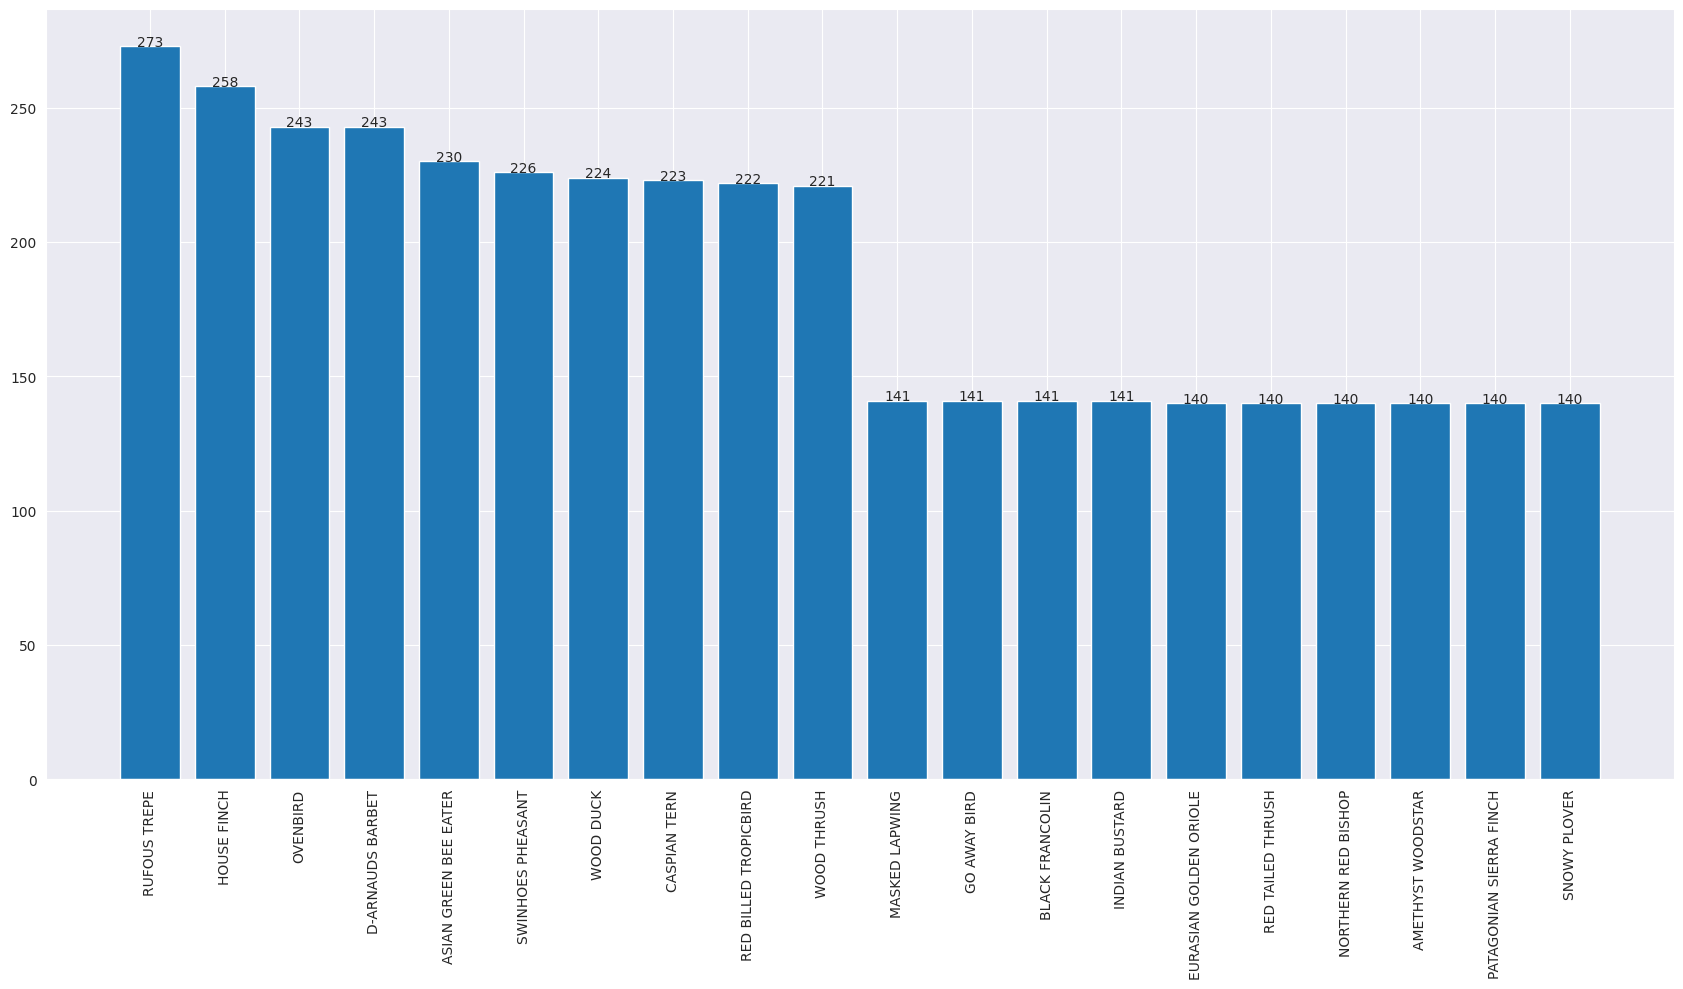

In [15]:
# Plotting the number of images for the 10 classes with the highest/lowest number of samples
plt.figure(figsize=(21,10))
plt.bar(classes, train_number_overview)
addlabels(classes, train_number_overview)
plt.xticks(classes, rotation='vertical')
plt.show()

## 2.3 Data Loading

First, when loading the images, some variables for their directories are created. The image sizes and channels are required for resizing and can also be used later in the construction of the neural network.

In [14]:
data_dir = '/content/100-bird-species/'
train_dir = data_dir + 'train/'
test_dir = data_dir + 'test/'
val_dir = data_dir + 'valid/'

In [15]:
BATCH_SIZE = 64

IMG_HEIGHT = 224
IMG_WIDTH = 224
CHANNELS = 3

Second, image_dataset_from_directory from tensorflow is used to load the images for the training, test and validation sets.

In [16]:
train_ds = image_dataset_from_directory(
    directory=train_dir,
    labels='inferred', # because they are contained in the directory structure
    label_mode='int', # ordinal encoding, suitable for sparse categorical crossentropy loss
    batch_size=BATCH_SIZE,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
)

val_ds = image_dataset_from_directory(
    directory=val_dir,
    labels='inferred', # because they are contained in the directory structure
    label_mode='int', # ordinal encoding, suitable for sparse categorical crossentropy loss
    batch_size=BATCH_SIZE,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
)

test_ds = image_dataset_from_directory(
    directory=test_dir,
    labels='inferred', # because they are contained in the directory structure
    label_mode='int', # ordinal encoding, suitable for sparse categorical crossentropy loss
    batch_size=BATCH_SIZE,
    shuffle=False, # shuffle is set to False as shuffle=True causes problems when predicting on the test set
    image_size=(IMG_HEIGHT, IMG_WIDTH),
)

Found 84635 files belonging to 525 classes.
Found 2625 files belonging to 525 classes.
Found 2625 files belonging to 525 classes.


In [17]:
class_names = train_ds.class_names
num_classes = len(class_names)
class_mapping = dict(zip(range(num_classes), class_names))

## 2.4 Overview of the images

The next two plots visualize images of the training and test set to to give an insight into the images to be trained/tested.

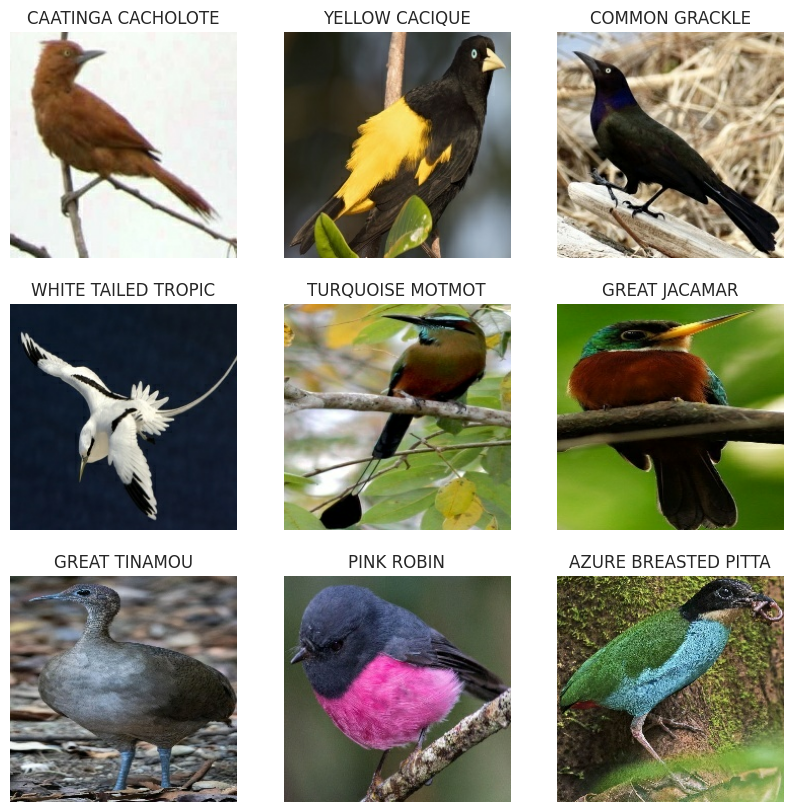

In [18]:
plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_names[labels[i]])
    plt.axis('off')

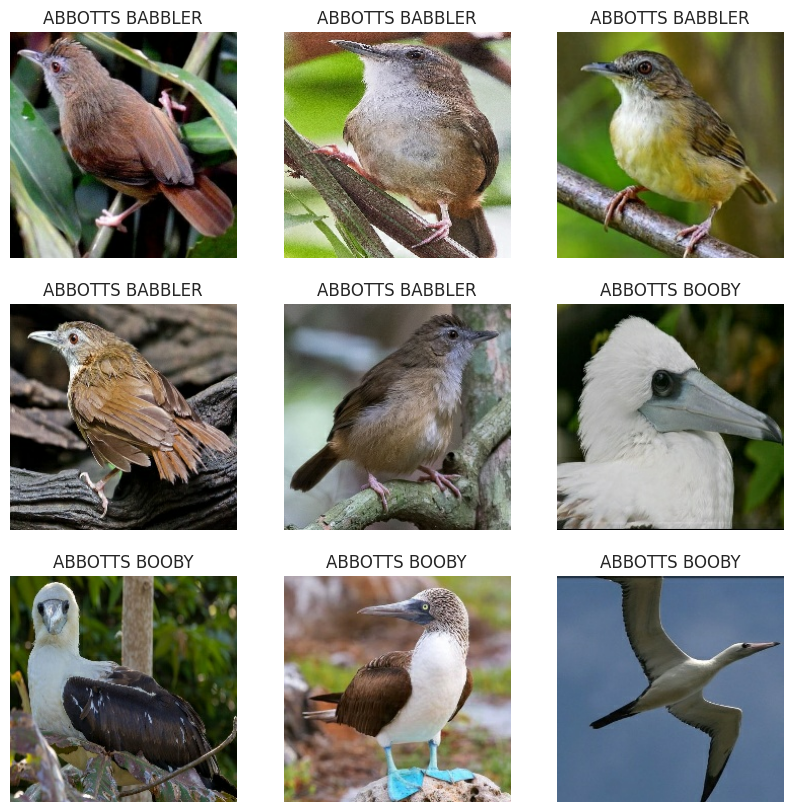

In [19]:
plt.figure(figsize=(10, 10))

for images, labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_names[labels[i]])
    plt.axis('off')

# 3. Model Implementation

## 3.1 Loading a pretrained model and the corresponding preprocessing

Switch-Cases to load the pretrained model selected in 1.3

In [ ]:
# Load the corresponding pretained model and preprocessing function
input_shape = (IMG_WIDTH, IMG_HEIGHT, CHANNELS)

match architecture:
  case 'EfficientNetB0':
    pretrained_model = tf.keras.applications.efficientnet.EfficientNetB0(
      input_shape=input_shape,
      classes=num_classes,
      include_top=False, # we don`t need a pre-trained top layer (output layer)
      weights=weights,
      pooling='max'
    )

    preprocess_input = tf.keras.applications.efficientnet.preprocess_input

  case 'EfficientNetB3':
    pretrained_model = tf.keras.applications.efficientnet.EfficientNetB3(
      input_shape=input_shape,
      classes=num_classes,
      include_top=False, # we don`t need a pre-trained top layer (output layer)
      weights=weights,
      pooling='max'
    )

    preprocess_input = tf.keras.applications.efficientnet.preprocess_input

  case 'EfficientNetB5':
    pretrained_model = tf.keras.applications.efficientnet.EfficientNetB5(
      input_shape=input_shape,
      classes=num_classes,
      include_top=False, # we don`t need a pre-trained top layer (output layer)
      weights=weights,
      pooling='max'
    )

    preprocess_input = tf.keras.applications.efficientnet.preprocess_input

  case 'EfficientNetB7':
    pretrained_model = tf.keras.applications.efficientnet.EfficientNetB7(
      input_shape=input_shape,
      classes=num_classes,
      include_top=False, # we don`t need a pre-trained top layer (output layer)
      weights=weights,
      pooling='max'
    )

    preprocess_input = tf.keras.applications.efficientnet.preprocess_input

  case 'VGG16':
    pretrained_model = tf.keras.applications.vgg16.VGG16(
      input_shape=input_shape,
      classes=num_classes,
      include_top=False, # we don`t need a pre-trained top layer (output layer)
      weights=weights,
      pooling='max'
    )

    preprocess_input = tf.keras.applications.vgg16.preprocess_input

  case _: # base case is resnet101
    pretrained_model = tf.keras.applications.resnet.ResNet101(
      input_shape=input_shape,
      classes=num_classes,
      include_top=False, # we don`t need a pre-trained top layer (output layer)
      weights=weights,
      pooling='max'
    )

    preprocess_input = tf.keras.applications.resnet.preprocess_input

# Freezing the layers of a pretrained neural network
pretrained_model.trainable = trainable

### 3.1.1 Plotting the pretrained model's architecture

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.873018 to fit



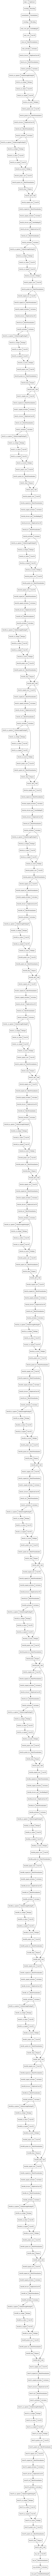

In [ ]:
plot_model(pretrained_model)

## 3.2 Implementing data augmentation

First, several layers are used as preprocessing layers, which increase the available amount of data by rotating, zooming, croping and translating the images.

In [ ]:
# Data Augmentation Step
augment = tf.keras.Sequential([
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.1),
  layers.RandomFlip("vertical"),
  layers.RandomTranslation(0.1, 0.1),
  layers.RandomContrast(0.1),
], name='AugmentationLayer')


## 3.3 Combining the model parts

As the images are 224x224 and there are 525 classes to predict there are 4 relatively large classification layers added behind the CNN.

In [ ]:
inputs = layers.Input(shape = (IMG_HEIGHT, IMG_WIDTH, CHANNELS), name='inputLayer')
x = augment(inputs)
x = preprocess_input(x)
x = pretrained_model(x, training = False)
x = layers.Flatten()(x)
x = layers.Dense(4096, activation='relu')(x)
# x = layers.Dropout(0.25)(x)
x = layers.Dense(2048, activation='relu')(x)
# x = layers.Dropout(0.25)(x)
x = layers.Dense(1024, activation='relu')(x)

outputs = layers.Dense(525, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputLayer (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 AugmentationLayer (Sequent  (None, 224, 224, 3)       0         
 ial)                                                            
                                                                 
 efficientnetb3 (Functional  (None, 1536)              10783535  
 )                                                               
                                                                 
 flatten (Flatten)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 4096)              6295552   
                                                                 
 dense_1 (Dense)             (None, 2048)              839065

## 3.4 Model Training

The model is trained for 100 epochs, with early stopping monitoring the loss on the validation set to avoid overfitting or needlessly long training times.

In [ ]:
epochs = 100

early_stopping = tf.keras.callbacks.EarlyStopping(patience = 5,
                                                  verbose = 2,
                                                  restore_best_weights = True)

history = model.fit(train_ds,
                    steps_per_epoch = len(train_ds),
                    validation_data = val_ds,
                    validation_steps = len(val_ds),
                    epochs = epochs,
                    batch_size = BATCH_SIZE,
                    callbacks = early_stopping)

## 3.5 Visualization of Training

The following code plots the loss and accuracy over the course of the training.

The training is not visualized here as the model was trained in a previous version of the notebook and only loaded from drive for the evaluation. The plots of the training history can be found in the presentation and the report.

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,10])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## 3.6 Saving the trained model to drive

The following code saves the model to google drive.

In [ ]:
tf.__version__ # checking the tensorflow version as there is a bug in versions belwo 2.13 which prevent saving the model

'2.13.0'

In [ ]:
model.save('bird_brain_model.h5')

## 3.7 Loading the trained model from drive

To load the model properly it is recommended to create a link from the model to your personal google drive. After creating a link (Verknüpfung) to your personal drive and mounting it in this notebook, the path in the function should work.

In [20]:
model = tf.keras.models.load_model('/content/drive/MyDrive/bird_brain_model.h5') # loading the trained model from drive

# 4. Evaluation

## 4.1 Classification Metrics

First, the metrics are evaluated on the testing set using TensorFlows built-in methods.

In [21]:
results = model.evaluate(test_ds, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.48801
Test Accuracy: 85.37%


In [25]:
results_train = model.evaluate(train_ds, verbose=0)

print("    Test Loss: {:.5f}".format(results_train[0]))
print("Test Accuracy: {:.2f}%".format(results_train[1] * 100))

    Test Loss: 0.58804
Test Accuracy: 82.99%


In [24]:
results_val = model.evaluate(val_ds, verbose=0)

print("    Test Loss: {:.5f}".format(results_val[0]))
print("Test Accuracy: {:.2f}%".format(results_val[1] * 100))

    Test Loss: 0.55274
Test Accuracy: 84.53%


Then, predictions are made for the full testing set, which enables a more thorough evaluation for more metrics with sklearn's classification report.

In [22]:
true_valid_labels = []

for images, labels in test_ds:
    for label in labels:
        true_valid_labels.append(label.numpy())

predictions = model.predict(test_ds)
predictions_label = np.argmax(predictions, axis=1)

print(true_valid_labels[:10])
print(predictions_label[:10])

42/42 [==============================] - 12s 228ms/step
[0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
[0 0 0 0 0 1 1 9 9 1]


In [26]:
report = classification_report(true_valid_labels,
                            predictions_label, target_names=list(class_names))
print(report)

{'ABBOTTS BABBLER': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 5}, 'ABBOTTS BOOBY': {'precision': 0.75, 'recall': 0.6, 'f1-score': 0.6666666666666665, 'support': 5}, 'ABYSSINIAN GROUND HORNBILL': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 5}, 'AFRICAN CROWNED CRANE': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 5}, 'AFRICAN EMERALD CUCKOO': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 5}, 'AFRICAN FIREFINCH': {'precision': 0.6666666666666666, 'recall': 0.8, 'f1-score': 0.7272727272727272, 'support': 5}, 'AFRICAN OYSTER CATCHER': {'precision': 0.8333333333333334, 'recall': 1.0, 'f1-score': 0.9090909090909091, 'support': 5}, 'AFRICAN PIED HORNBILL': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 5}, 'AFRICAN PYGMY GOOSE': {'precision': 1.0, 'recall': 0.8, 'f1-score': 0.888888888888889, 'support': 5}, 'ALBATROSS': {'precision': 0.5555555555555556, 'recall': 1.0, 'f1-score': 0.7142857142857143, 'support'

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 4.2 Confusion Matrix

Based on the prediction, a different confusion matrices are created for a better understanding of the model performance. Because using all 525 classes is not very beneficial, the best/worst predicted classes are filtered and visualized in two confusion matrices.

First, a classification report as a DataFrame is created to enable filtering the classes according to the metrices.

In [47]:
report_df = pd.DataFrame(classification_report(true_valid_labels,
                            predictions_label, target_names=list(class_names), output_dict=True)).transpose()
report_df_cleaned = report_df[:-3] # deletion of the last three rows as they contain the average values over all classes
report_df_cleaned.tail()

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


precision  recall  f1-score  support
YELLOW BELLIED FLOWERPECKER        0.8     0.8  0.800000      5.0
YELLOW BREASTED CHAT               1.0     0.8  0.888889      5.0
YELLOW CACIQUE                     1.0     1.0  1.000000      5.0
YELLOW HEADED BLACKBIRD            1.0     0.8  0.888889      5.0
ZEBRA DOVE                         1.0     1.0  1.000000      5.0

Second, the classes are grouped into three categories, according to the precision of the model predcitions of the class. Additionally, all classes with perfect values for precision, recoil and F1-Score are saved.

In [48]:
bad_precision, medium_prediction, good_prediction, perfect_prediction = [], [], [], []

# filtering the lasses according to the reached precision values
for row in report_df_cleaned.iterrows():
  if row[1][0] <= 0.25:
    bad_precision.append(row[0])

  if row[1][0] <= 0.75 and row[1][0] > 0.25:
    medium_prediction.append(row[0])

  if row[1][0] > 0.75 and row[1][0] <= 1.0:
    good_prediction.append(row[0])

  if row[1][0] == 1.0 and  row[1][1] == 1.0 and  row[1][2] == 1.0:
    perfect_prediction.append(row[0])

Overview of how many classes belong to each of the three groups and how much classes were predicted perfectly.

In [51]:
print('Number of bad predicted classes: ', len(bad_precision))
print('Number of medium predicted classes: ', len(medium_prediction))
print('Number of good predicted classes: ', len(good_prediction))
print('Total number of predicted classes: ', len(bad_precision)+len(medium_prediction)+len(good_prediction))
print('')
print('Number of perfect predicted classes: ', len(perfect_prediction))

Number of bad predicted classes:  3
Number of medium predicted classes:  114
Number of good predicted classes:  408
Total number of predicted classes:  525

Number of perfect predicted classes:  168


Third, functions to preprocess the predictions for creating the confusion matrices.

Function to translate the class names to numerical labels as the predictions are numerical.

In [52]:
def translate_classes(input_list, classes_dict):
    keys_list = []
    for item in input_list:
        for key, value in classes_dict.items():
            if item == value:
                keys_list.append(key)
    return keys_list

Function to cut the predictions belonging to the classes out of the predictions list. Note, this is doable as the test data set was not shuffled and thus the classes are in order with 5 images each.

In [53]:
def cut_elements(predictions_to_select, all_predictions):
    result = []
    for element in predictions_to_select:
        start_index = element * 5
        end_index = start_index + 5
        result.extend(all_predictions[start_index:end_index])
    return result

Function to translate the extracted predictions back to words for a better understanding of the confusion matrices.

In [54]:
def translate_classes_2(input_list, classes_dict):
    result = []
    for item in input_list:
        if item in classes_dict:
            result.append(classes_dict[item])
    return result

Function to create the confusion matrices dynamically.

In [55]:
def create_confusion_matrix(y_true, y_predictions, ax_labels):
  cf = confusion_matrix(y_true, y_predictions)

  fig, ax = plt.subplots(figsize=(10,10))

  plot = sns.heatmap(cf,annot=True, cbar=False, yticklabels=ax_labels, xticklabels=ax_labels)

  plot.tick_params(labelsize=15)

  plt.xticks(rotation=90)
  plt.yticks(rotation=0)

  plt.ylabel('True label', size=20)
  plt.xlabel('Predicted label', size=20)

  plt.show()

Calling all above functions to get the data for the bad, good and perfect predicted classes to create the confusion matrices.

In [77]:
mapped_keys_bad_precision = translate_classes(bad_precision, class_mapping)

mapped_keys_good_prediction = translate_classes(good_prediction[:15], class_mapping) # selecting only the first 15 classes as the confusion matrix would otherwise be to huge

mapped_keys_perfect_prediction = translate_classes(perfect_prediction[:15], class_mapping) # selecting only the first 15 classes as the confusion matrix would otherwise be to huge

In [78]:
elements_for_cf_labels_bad_precision = cut_elements(mapped_keys_bad_precision, true_valid_labels)
elements_for_cf_predictions_bad_precision = cut_elements(mapped_keys_bad_precision, predictions_label)

elements_for_cf_labels_good_prediction = cut_elements(mapped_keys_good_prediction, true_valid_labels)
elements_for_cf_predictions_good_prediction = cut_elements(mapped_keys_good_prediction, predictions_label)

elements_for_cf_labels_perfect_prediction = cut_elements(mapped_keys_perfect_prediction, true_valid_labels)
elements_for_cf_predictions_perfect_prediction = cut_elements(mapped_keys_perfect_prediction, predictions_label)

In [79]:
elements_for_cf_labels_bad_precision = translate_classes_2(elements_for_cf_labels_bad_precision, class_mapping)
elements_for_cf_predictions_bad_precision = translate_classes_2(elements_for_cf_predictions_bad_precision, class_mapping)

elements_for_cf_labels_good_prediction = translate_classes_2(elements_for_cf_labels_good_prediction, class_mapping)
elements_for_cf_predictions_good_prediction = translate_classes_2(elements_for_cf_predictions_good_prediction, class_mapping)

elements_for_cf_labels_perfect_prediction = translate_classes_2(elements_for_cf_labels_perfect_prediction, class_mapping)
elements_for_cf_predictions_perfect_prediction = translate_classes_2(elements_for_cf_predictions_perfect_prediction, class_mapping)

Creating the Confusion Matrices for the classes with bad, good and perfect precision.

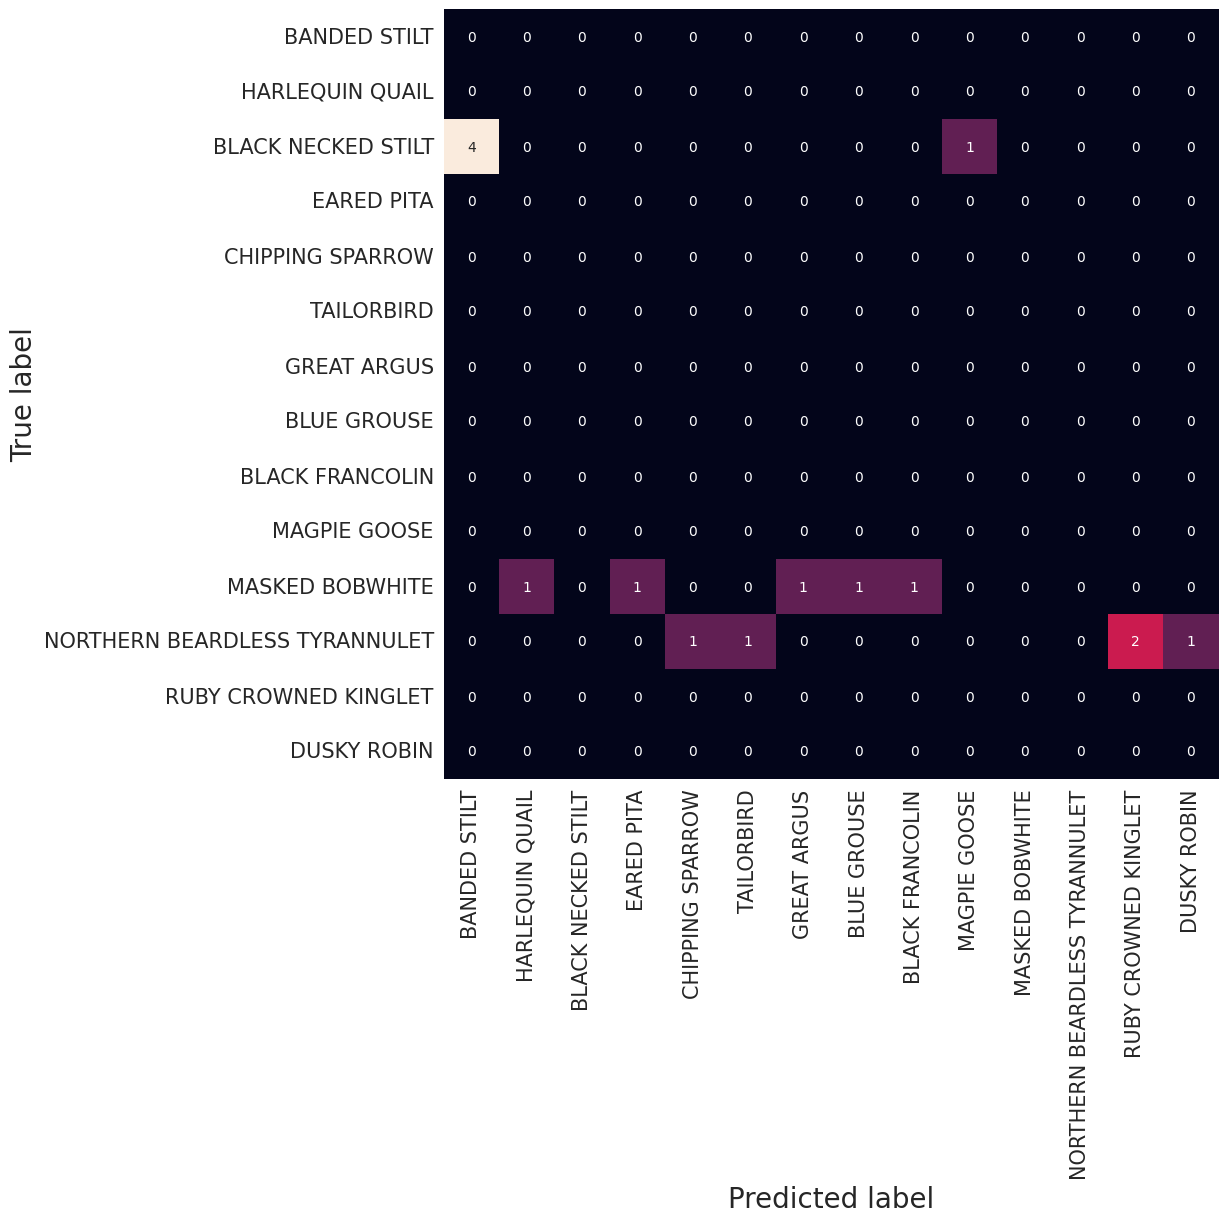

In [80]:
# manually defining the axe labels as the predictions are that bad that three input classes result in 15 predicted classes
labels_cf = ['BANDED STILT', 'HARLEQUIN QUAIL', 'BLACK NECKED STILT', 'EARED PITA', 'CHIPPING SPARROW', 'TAILORBIRD','GREAT ARGUS','BLUE GROUSE','BLACK FRANCOLIN','MAGPIE GOOSE', 'MASKED BOBWHITE','NORTHERN BEARDLESS TYRANNULET','RUBY CROWNED KINGLET', 'DUSKY ROBIN']

create_confusion_matrix(elements_for_cf_labels_bad_precision, elements_for_cf_predictions_bad_precision, labels_cf)

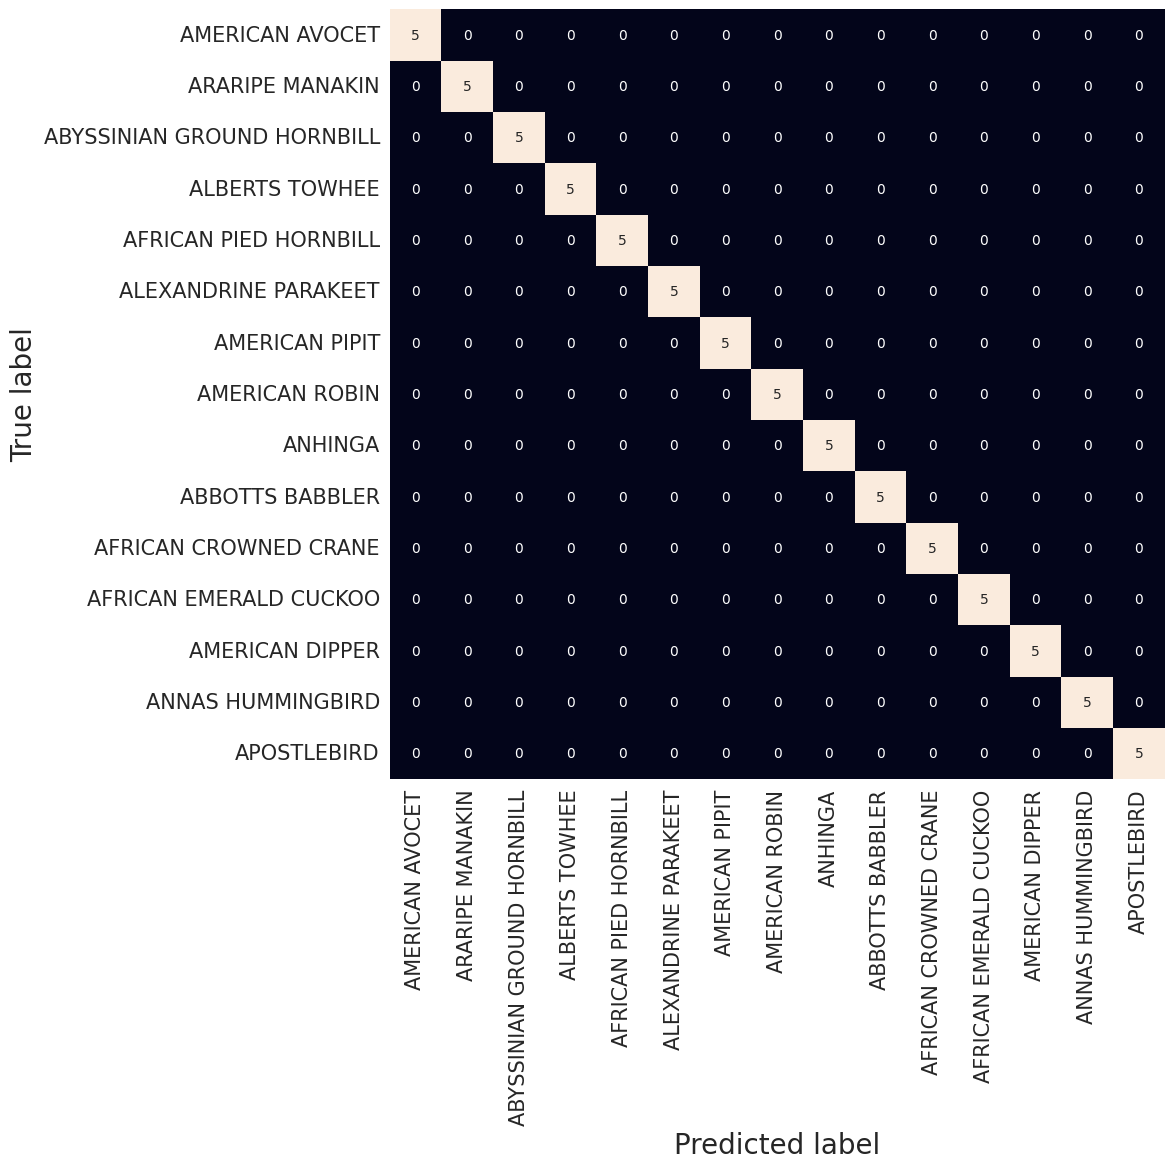

In [81]:
# creating a set with the lables to use them as axis ticks
labels_cf = set(elements_for_cf_labels_perfect_prediction)

create_confusion_matrix(elements_for_cf_labels_perfect_prediction, elements_for_cf_predictions_perfect_prediction, labels_cf)

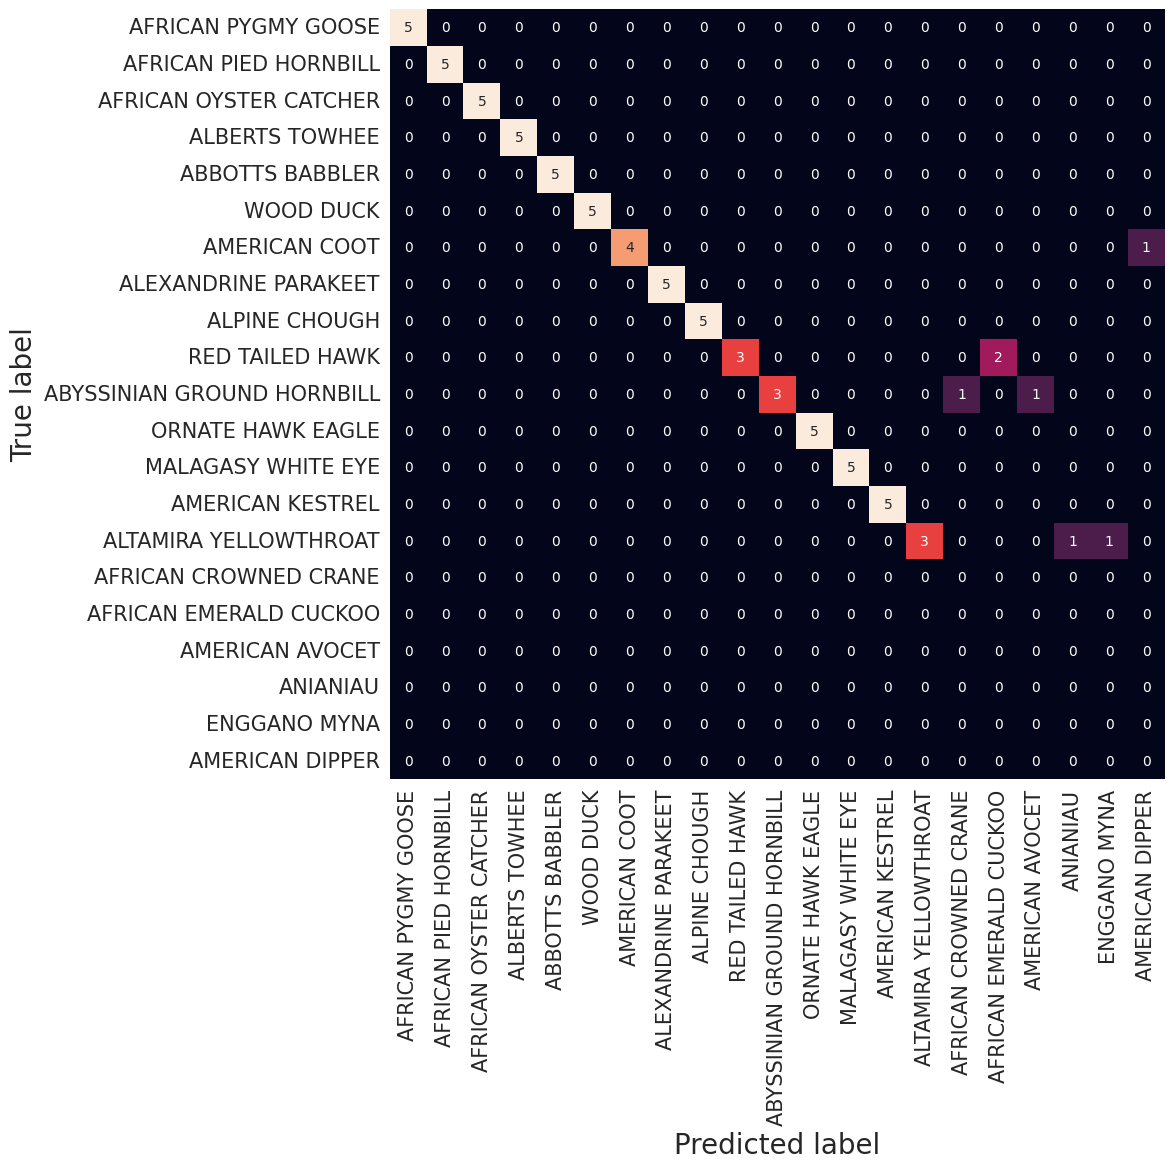

In [82]:
# creating a set with the lables to use them as axis ticks
labels_cf = set(elements_for_cf_predictions_good_prediction)

create_confusion_matrix(elements_for_cf_labels_good_prediction, elements_for_cf_predictions_good_prediction, labels_cf)